In [192]:
from os import listdir
from scipy import sparse
import numpy as np

import random
from collections import namedtuple, Counter

import matplotlib.pyplot as plt

from sklearn import metrics

In [103]:
chrom = '18'

family_sizes = [6, 5, 4, 3]
phase_dir = '../phased_ihart'
data_dir = '../split_gen_ihart'

In [7]:
# load genotypes
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])
print(gen_files)

# use only "cleaned" variants - must be SNPs
coordinates = np.load(coord_file)
snp_positions = coordinates[:, 1]
snp_indices = coordinates[:, 2]==1
snp_positions = snp_positions[snp_indices]

gen_data = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])
gen_data = gen_data[:, snp_indices]
gen_data[gen_data==-2] = -1
    
    

['chr.18.0.gen.npz', 'chr.18.1.gen.npz']


In [247]:
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_id_to_index = dict([(x.strip(), i) for i, x in enumerate(f)])

In [224]:
from collections import defaultdict

# load deletions from all chromosomes
Deletion = namedtuple('Deletion', ['family', 'chrom', 
                                   'start_pos', 'end_pos', 'length',
                                   'opt_start_pos', 'opt_end_pos', 'opt_length',
                                   'trans', 'notrans',
                                   'is_mat', 'is_pat', 'mother', 'father'])
deletions = []

messy_transmission = 0
double_del = 0
not_inherited = 0

family_to_individuals = dict()
mothers, fathers = set(), set()
for j in family_sizes:
    try:
        with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header
            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                individuals = pieces[1:(1+j)]
                if individuals[0] not in mothers and individuals[1] not in fathers:
                    family_to_individuals[family_key] = individuals
                    mothers.add(individuals[0])
                    fathers.add(individuals[1])

        # load deletions
        family_to_states = defaultdict(list)
        family_to_pos = defaultdict(list)
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                inheritance_state = [int(x) for x in pieces[1:(1+(j*2))]]
                start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]

                family_to_states[family_key].append(inheritance_state)
                family_to_pos[family_key].append((start_pos, end_pos))
                 
        # pull deletions from each family
        for family_key, states in family_to_states.items():
            if family_key in family_to_individuals:
                states = np.asarray(states)
                positions = np.asarray(family_to_pos[family_key])
                mother, father = family_to_individuals[family_key][:2]
                children = family_to_individuals[family_key][2:]

                # for each ancestral chromosome
                for i in range(4):
                    start_indices = np.where((states[:-1, i] != 0) & (states[1:, i] == 0))[0]
                    end_indices = np.where((states[:-1, i] == 0) & (states[1:, i] != 0))[0]

                    for s_ind, e_ind in zip(start_indices, end_indices):
                        # this is a deletion, identify endpoints
                        b, c = s_ind+1, e_ind+1
                        last_prev_unknown = np.where(states[:s_ind+1, i]!=-1)[0]
                        first_next_unknown = np.where(states[e_ind+1:, i]!=-1)[0]

                        if last_prev_unknown.shape[0] > 0:
                            a = last_prev_unknown[-1]+1
                        else:
                            a = 0

                        if first_next_unknown.shape[0] > 0:
                            d = first_next_unknown[0]+e_ind+1
                        else:
                            d = states.shape[0]

                        start_pos, end_pos = positions[b, 0], positions[c-1, 1]
                        opt_start_pos, opt_end_pos = positions[a, 0], positions[d-1, 1]

                        assert start_pos < end_pos
                        assert opt_start_pos <= start_pos
                        assert end_pos <= opt_end_pos

                        # now check if transmitted cleanly
                        s = states[b, 4:]
                        if i == 0 or i == 1:
                            # maternal deletion
                            cleanly_transmitted = np.all(s[np.arange(0, s.shape[0], 2)]!=-1)
                            for t in states[b:c, 4:]:
                                cleanly_transmitted = cleanly_transmitted and np.all(np.equal(t[np.arange(0, s.shape[0], 2)], s[np.arange(0, s.shape[0], 2)]))
                        else:
                            # paternal deletion
                            cleanly_transmitted = np.all(s[np.arange(1, s.shape[0], 2)]!=-1)
                            for t in states[b:c, 4:]:
                                cleanly_transmitted = cleanly_transmitted and np.all(np.equal(t[np.arange(1, s.shape[0], 2)], s[np.arange(1, s.shape[0], 2)]))

                        # check if double deletion
                        is_double = False
                        if i == 0 and np.any(states[b:c, 1] == 0):
                            is_double = True
                        elif i == 1 and np.any(states[b:c, 0] == 0):
                            is_double = True
                        elif i == 2 and np.any(states[b:c, 3] == 0):
                            is_double = True
                        elif i == 3 and np.any(states[b:c, 2] == 0):
                            is_double = True
                            
                        # check if the deletion has been inherited
                        was_inherited = False
                        if (i == 0) and not np.all(s[np.arange(0, s.shape[0], 2)]==1):
                            was_inherited = True
                        if (i == 1) and not np.all(s[np.arange(0, s.shape[0], 2)]==0):
                            was_inherited = True
                        if (i == 2) and not np.all(s[np.arange(1, s.shape[0], 2)]==1):
                            was_inherited = True
                        if (i == 3) and not np.all(s[np.arange(1, s.shape[0], 2)]==0):
                            was_inherited = True

                        if is_double:
                            double_del += 1
                        if not cleanly_transmitted:
                            messy_transmission += 1
                        if not was_inherited:
                            not_inherited += 1

                        if (not is_double) and cleanly_transmitted and was_inherited:
                            if i == 0:
                                trans = [children[x] for x in np.where(s[range(0, 2*len(children), 2)]==0)[0]]
                                notrans = [children[x] for x in np.where(s[range(0, 2*len(children), 2)]!=0)[0]]
                            elif i == 1:
                                trans = [children[x] for x in np.where(s[range(0, 2*len(children), 2)]==1)[0]]
                                notrans = [children[x] for x in np.where(s[range(0, 2*len(children), 2)]!=1)[0]]
                            elif i == 2:
                                trans = [children[x] for x in np.where(s[range(1, 2*len(children), 2)]==0)[0]]
                                notrans = [children[x] for x in np.where(s[range(1, 2*len(children), 2)]!=0)[0]]
                            elif i == 3:
                                trans = [children[x] for x in np.where(s[range(1, 2*len(children), 2)]==1)[0]]
                                notrans = [children[x] for x in np.where(s[range(1, 2*len(children), 2)]!=1)[0]]
                            deletions.append(Deletion(family_key, chrom, 
                                                              start_pos, end_pos, end_pos-start_pos+1,
                                                              opt_start_pos, opt_end_pos, opt_end_pos-opt_start_pos+1,
                                                              trans, notrans, i<2, i>=2, mother, father))

    except FileNotFoundError:
        print('File not found', 'chrom', chrom, 'fammily size', j)
    except StopIteration:
        print('File empty', 'chrom', chrom, 'family size', j)
                
print('\nMessy transmissions', messy_transmission)
print('Double deletions', double_del)
print('Not inherited', not_inherited)

print('Deletions', len(deletions), 'Maternal', len([x for x in deletions if x.is_mat]), 'Paternal', len([x for x in deletions if x.is_pat]))




Messy transmissions 0
Double deletions 0
Not inherited 0
Deletions 1069 Maternal 553 Paternal 516


In [129]:
Nodeletion = namedtuple('Nodeletion', ['parent', 'chrom', 'start_pos', 'end_pos', 'length'])
parent_to_nodeletion = defaultdict(list)

for j in family_sizes:
    # load uninherited segments
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header

        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            
            if family_key in family_to_individuals:
                inheritance_state = [int(x) for x in pieces[1:(1+(j*2))]]
                start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]

                individuals = family_to_individuals[family_key]

                # check if mom is uninherited
                mom_inh = [inheritance_state[4+(2*i)] for i in range(j-2)]
                if inheritance_state[0] == 1 and inheritance_state[1] == 1 \
                    and len([x for x in mom_inh if x == 0])>0 \
                    and len([x for x in mom_inh if x == 1])>0:
                    # mom does not have a deletion here
                    parent_to_nodeletion[individuals[0]].append(Nodeletion(individuals[0], chrom, 
                                                              start_pos, end_pos, end_pos-start_pos+1))

                # check if dad is uninherited
                dad_inh = [inheritance_state[5+(2*i)] for i in range(j-2)]
                if inheritance_state[2] == 1 and inheritance_state[3] == 1 \
                    and len([x for x in dad_inh if x == 0])>0 \
                    and len([x for x in dad_inh if x == 1])>0:
                    # dad does not have a deletion here
                    parent_to_nodeletion[individuals[1]].append(Nodeletion(individuals[1], chrom, 
                                                              start_pos, end_pos, end_pos-start_pos+1))
        

In [130]:
print(random.choice(deletions))
print(random.choice(list(parent_to_nodeletion.items())))

Deletion(family='AU0923.AU0923202.AU0923201', chrom='18', start_pos=4448130, end_pos=4477715, length=29586, opt_start_pos=4447883, opt_end_pos=4477789, opt_length=29907, trans=['AU0923301'], notrans=['AU0923302'], is_mat=False, is_pat=True, mother='AU0923202', father='AU0923201')
('AU1226201', [Nodeletion(parent='AU1226201', chrom='18', start_pos=1, end_pos=6495624, length=6495624), Nodeletion(parent='AU1226201', chrom='18', start_pos=6495625, end_pos=6497001, length=1377), Nodeletion(parent='AU1226201', chrom='18', start_pos=6497002, end_pos=7005737, length=508736), Nodeletion(parent='AU1226201', chrom='18', start_pos=37685765, end_pos=69361739, length=31675975), Nodeletion(parent='AU1226201', chrom='18', start_pos=69361740, end_pos=69362682, length=943), Nodeletion(parent='AU1226201', chrom='18', start_pos=69362683, end_pos=78077248, length=8714566)])


In [306]:
d = random.choice(deletions)
print(d)

positive_sample_ids = set()
negative_sample_ids = set()

for d2 in deletions:
    overlap = 0
    if (d.start_pos <= d2.start_pos) and (d.end_pos >= d2.start_pos):
        overlap = min(d.end_pos, d2.end_pos) - d2.start_pos + 1
    elif (d2.start_pos <= d.start_pos) and (d2.end_pos >= d.start_pos):
        overlap = min(d2.end_pos, d.end_pos) - d.start_pos + 1
    
    if (overlap/d.length > 0.75) and (overlap/d2.length > 0.75):
        if d2.is_mat:
            #print(d2.mother, overlap/d.length, overlap/d2.length, d2.start_pos, d2.end_pos)
            positive_sample_ids.add(d2.mother)
        if d2.is_pat:
            #print(d2.father, overlap/d.length, overlap/d2.length, d2.start_pos, d2.end_pos)
            positive_sample_ids.add(d2.father)
            
for parent, nodeletions in parent_to_nodeletion.items():
    for nd in nodeletions:
        overlap = 0
        if (d.start_pos <= nd.start_pos) and (d.end_pos >= nd.start_pos):
            overlap = min(d.end_pos, nd.end_pos) - nd.start_pos + 1
        elif (nd.start_pos <= d.start_pos) and (nd.end_pos >= d.start_pos):
            overlap = min(nd.end_pos, d.end_pos) - d.start_pos + 1

        if (overlap/d.length == 1):
            #print(parent, overlap/d.length, nd.start_pos, nd.end_pos)
            negative_sample_ids.add(parent)
    
unknown_sample_ids = (mothers | fathers) - (positive_sample_ids | negative_sample_ids)
print(len(positive_sample_ids), len(negative_sample_ids), len(unknown_sample_ids))
print(negative_sample_ids & positive_sample_ids)

Deletion(family='AU1574.AU1574202.AU1574201', chrom='18', start_pos=14288810, end_pos=14304764, length=15955, opt_start_pos=14285328, opt_end_pos=14304774, opt_length=19447, trans=['AU1574303', 'AU1574301', 'AU1574302'], notrans=[], is_mat=False, is_pat=True, mother='AU1574202', father='AU1574201')
12 727 993
set()


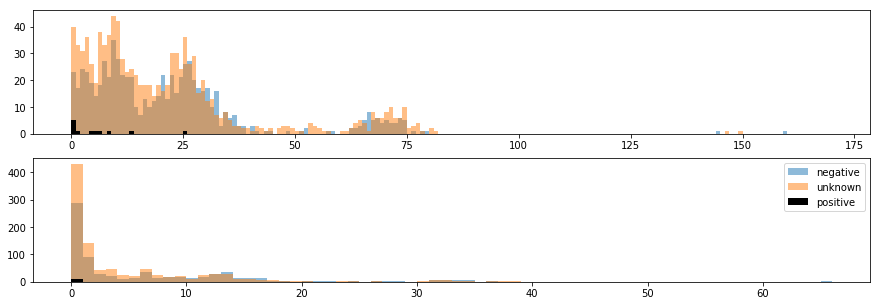

In [307]:
het_sites = (gen_data[:, (snp_positions>=d.start_pos) & (snp_positions<=d.end_pos)]==1).sum(axis=1).A.flatten()
homalt_sites = (gen_data[:, (snp_positions>=d.start_pos) & (snp_positions<=d.end_pos)]==2).sum(axis=1).A.flatten()

positive_indices = [sample_id_to_index[x] for x in positive_sample_ids]
negative_indices = [sample_id_to_index[x] for x in negative_sample_ids]
unknown_indices = [sample_id_to_index[x] for x in unknown_sample_ids]

plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
plt.hist(het_sites[negative_indices], label='negative', 
         alpha=0.5, bins=range(0, np.max(het_sites)))
plt.hist(het_sites[unknown_indices], label='unknown', 
         alpha=0.5, bins=range(0, np.max(het_sites)))
plt.hist(het_sites[positive_indices], label='positive', 
         bins=range(0, np.max(het_sites)), color='black')

plt.subplot(2, 1, 2)
max_value = int(np.max(het_sites/(1+homalt_sites)))
plt.hist(het_sites[negative_indices]/(1+homalt_sites[negative_indices]), label='negative', 
         alpha=0.5, bins=range(0, max_value))
plt.hist(het_sites[unknown_indices]/(1+homalt_sites[unknown_indices]), label='unknown', 
         alpha=0.5, bins=range(0, max_value))
plt.hist(het_sites[positive_indices]/(1+homalt_sites[positive_indices]), label='positive', 
         bins=range(0, max_value), color='black')

plt.legend()
plt.show()

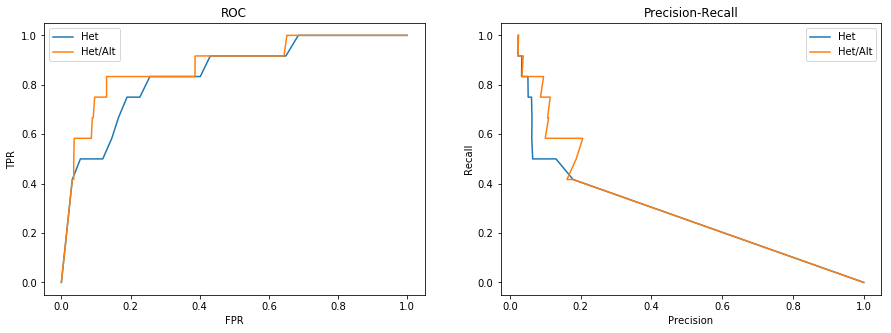

In [308]:


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
true_labels = np.hstack((np.ones((len(positive_indices),)), np.zeros((len(negative_indices),))))
scores = -het_sites[positive_indices+negative_indices]
fpr, tpr, thresholds = metrics.roc_curve(true_labels, scores)
plt.plot(fpr, tpr, label='Het')

scores = -het_sites[positive_indices+negative_indices]/(1+homalt_sites[positive_indices+negative_indices])
fpr, tpr, thresholds = metrics.roc_curve(true_labels, scores)
plt.plot(fpr, tpr, label='Het/Alt')

plt.legend()
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.subplot(1, 2, 2)
true_labels = np.hstack((np.ones((len(positive_indices),)), np.zeros((len(negative_indices),))))
scores = -het_sites[positive_indices+negative_indices]
p, r, thresholds = metrics.precision_recall_curve(true_labels, scores)
plt.plot(p, r, label='Het')

scores = -het_sites[positive_indices+negative_indices]/(1+homalt_sites[positive_indices+negative_indices])
p, r, thresholds = metrics.precision_recall_curve(true_labels, scores)
plt.plot(p, r, label='Het/Alt')


plt.legend()
plt.title('Precision-Recall')
plt.xlabel('Precision')
plt.ylabel('Recall')

plt.legend()
plt.show()